<a href="https://colab.research.google.com/github/jesminmousumy/Python-Programming/blob/main/Predictive_Analytics_in_Healthcare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No

<ipython-input-2-9f55ba178161>:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  readmission_by_age = df.groupby('age_group')[readmission_col].value_counts(normalize=True).unstack()


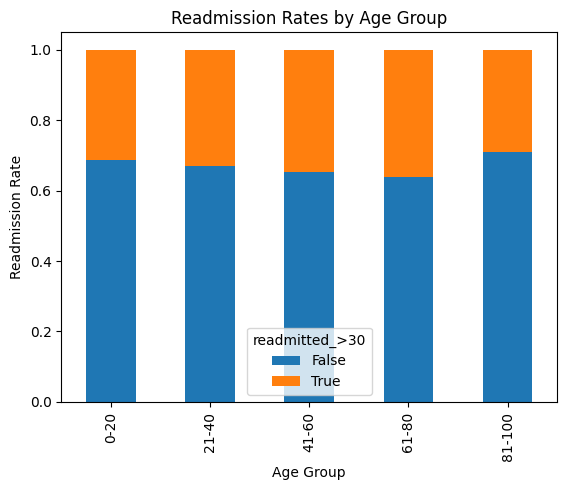

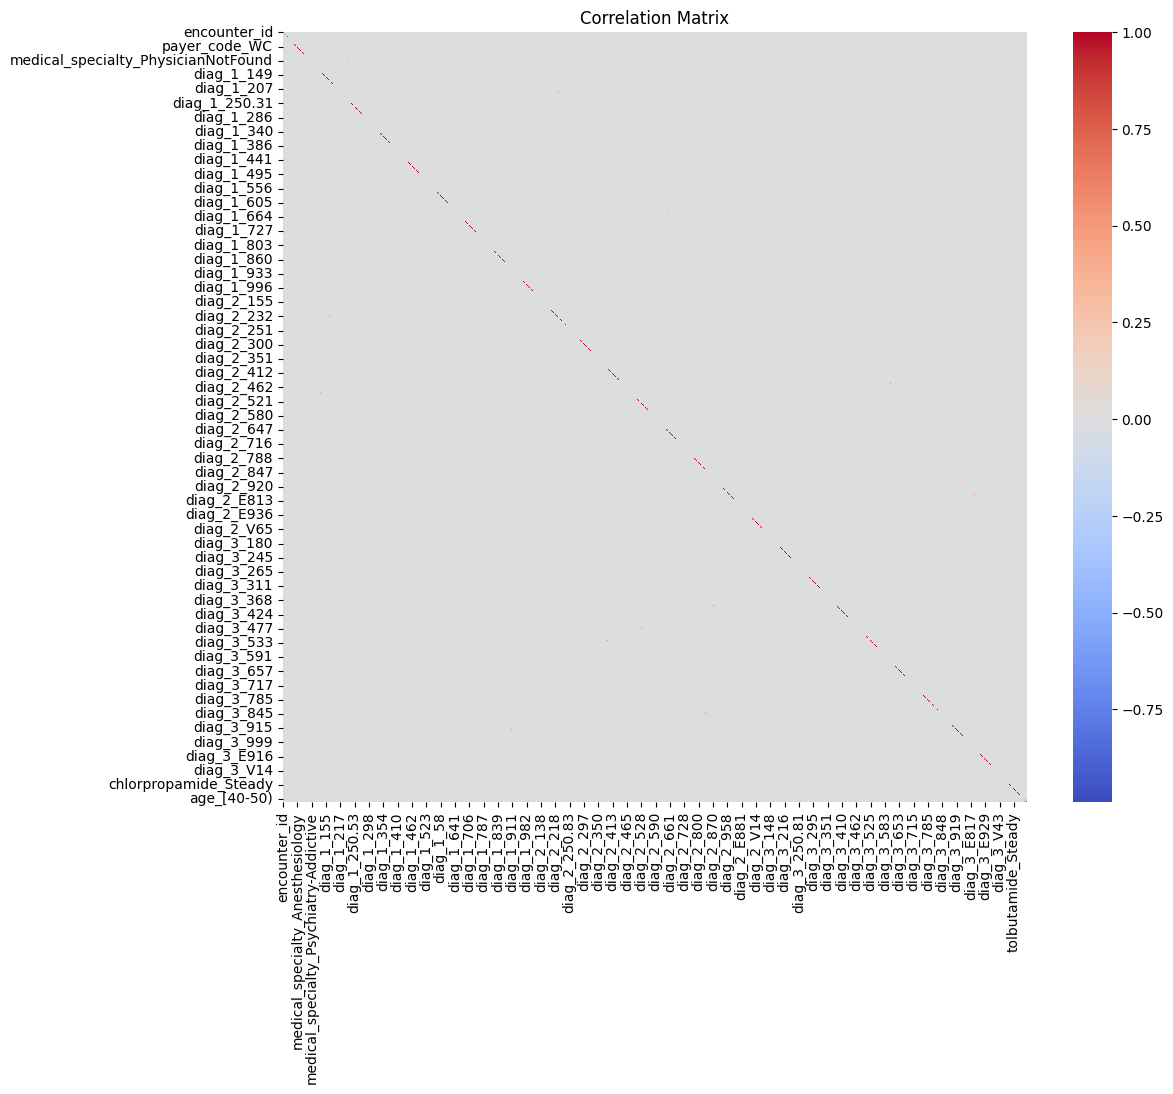

NameError: name 'pipeline' is not defined

In [ ]:
# Step 1: Data Collection
# Dataset: Diabetes 130-US Hospitals Dataset on Kaggle
# Download the dataset from Kaggle and load it into the environment.


#import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
#import columnTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

#load the dataset
df = pd.read_csv('diabetic_data.csv')


#display the first few rows of the dataframme
print(df.head())

# Step 2: Data Preparation

# Encode Categorical Features (One-Hot Encoding)
categorical_cols = [col for col in df.columns if df[col].dtype == 'object' and col != 'age'] # Exclude 'age' from one-hot encoding
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True) #drop_first avoids multicollinearity

# Handle Missing Values (using more robust strategy)
# Identify columns with missing data
missing_data = df.isnull().sum()
print("Missing Data:\n", missing_data)

# Fill missing values in numerical columns with the median and categorical columns with 'unknown'
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='constant', fill_value='unknown')

# Encode Categorical Features
# One-hot encode categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_imputer, numerical_cols),
        ('cat', categorical_imputer, categorical_cols),
        ('cat_encode', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Feature Scaling
# Normalize continuous variables using StandardScaler
scaler = StandardScaler()

# Step 3: Exploratory Data Analysis (EDA)
# Analyze Readmission Trends by Age Group
# Step 3: Exploratory Data Analysis (EDA)
# Analyze Readmission Trends by Age Group
df['age_group'] = pd.cut(df['age'].str.extract('(\d+)').astype(int).squeeze(),
                         bins=[0, 20, 40, 60, 80, 100],
                         labels=['0-20', '21-40', '41-60', '61-80', '81-100'])

# Assuming 'readmitted' was one-hot encoded into 'readmitted_NO', 'readmitted_<30', '>30'
# Choose the specific column you want to analyze
readmission_col = 'readmitted_>30'  # Or 'readmitted_NO' or 'readmitted_<30'

readmission_by_age = df.groupby('age_group')[readmission_col].value_counts(normalize=True).unstack()
readmission_by_age.plot(kind='bar', stacked=True)
plt.title('Readmission Rates by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Readmission Rate')
plt.show()

# Visualize Correlations
# Convert categorical variables to numerical for correlation analysis

df_encoded = pd.get_dummies(df,drop_first=True)
corr_matrix = df_encoded.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#step 4: Modeling
#split Data into Training and Test sets
# The 'readmitted' column was likely one-hot encoded into multiple columns.
# Identify the columns representing 'readmitted' (e.g., 'readmitted_NO', 'readmitted_<30', 'readmitted_>30')
# and drop them instead.
readmitted_cols = [col for col in df.columns if 'readmitted' in col]  # Find columns containing 'readmitted'
X = df.drop(columns=readmitted_cols, axis=1) # Drop the readmitted columns

# Assuming the target variable is now represented by a column like 'readmitted_>30'
# (or whichever column you're interested in predicting)
y = df['readmitted_>30']  # Select the appropriate target column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Create a pipeline for preprocessing and Modeling
model = pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', scaler),
    ('classifier', LogisticRegression(max_iter=1000))
])

#Train a Logistic Regression Model
model.fit(X_train, y_train)

#Make Predictions on the Test Set
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
classification_rep = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", confusion_mat)


#Step 5 Insights
# Feature Importance
#Extract feature importance from the logistic regression model
feature_importance = model.named_steps['classifier'].coef_[0]
feature_names = importance_df.sort_values(by='Importance', ascending=False)

print("Top 10 Features by Importance:", feature_names.head(10))

